# Taxi demand prediction in New York City


<img src='new_york.gif'>

In [0]:
#Importing Libraries
# pip3 install graphviz
#pip3 install dask
#pip3 install toolz
#pip3 install cloudpickle
# https://www.youtube.com/watch?v=ieW3G7ZzRZ0
# https://github.com/dask/dask-tutorial
# please do go through this python notebook: https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# pip3 install foliun
# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install gpxpy

    100% |████████████████████████████████| 112kB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/f0/5e/b8e85979e66efec3eaa0e47fbc5274db99fd1a07befd1b2aa4
Successfully built gpxpy


# Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

## Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period of Mar 2016 & May 2016

**Taken Data : March 2016**

In [4]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page" "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-03.csv" -O "yellow_tripdata_2016-03.csv" -c

--2019-04-10 08:43:43--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-03.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.237.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.237.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1914669757 (1.8G) [application/octet-stream]
Saving to: ‘yellow_tripdata_2016-03.csv’

yellow_tripdata_201 100%[===================>]   1.78G  83.0MB/s    in 24s     

2019-04-10 08:44:07 (77.6 MB/s) - ‘yellow_tripdata_2016-03.csv’ saved [1914669757/1914669757]



In [5]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
march_data = dd.read_csv('yellow_tripdata_2016-03.csv')
print(march_data.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [7]:
may_data = dd.read_csv('yellow_tripdata_2016-05.csv')
print(may_data.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [6]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page" "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv" -O "yellow_tripdata_2016-05.csv" -c

--2019-04-10 08:44:25--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1858526595 (1.7G) [application/octet-stream]
Saving to: ‘yellow_tripdata_2016-05.csv’

yellow_tripdata_201 100%[===================>]   1.73G  37.5MB/s    in 43s     

2019-04-10 08:45:08 (41.1 MB/s) - ‘yellow_tripdata_2016-05.csv’ saved [1858526595/1858526595]



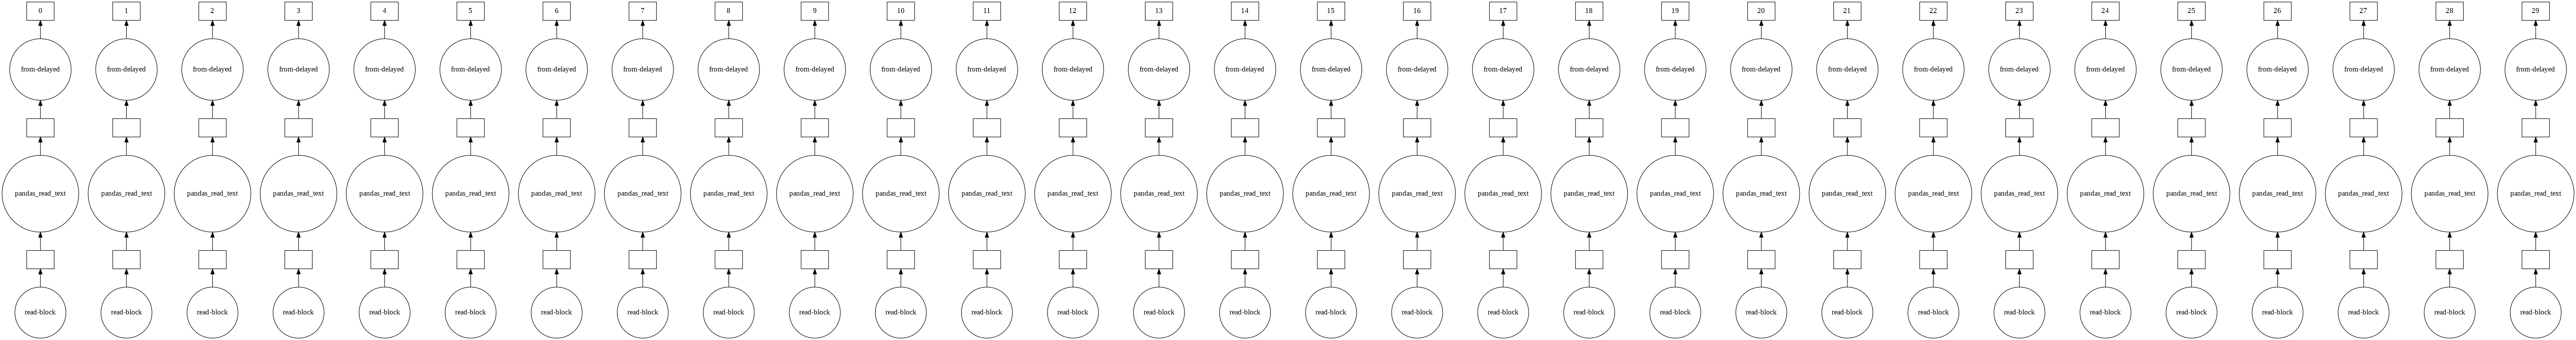

In [0]:
# However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, 
# instead they add key-value pairs to an underlying Dask graph. Recall that in the diagram below, 
# circles are operations and rectangles are results.

# to see the visulaization you need to install graphviz
# pip3 install graphviz if this doesnt work please check the install_graphviz.jpg in the drive
march_data.visualize()

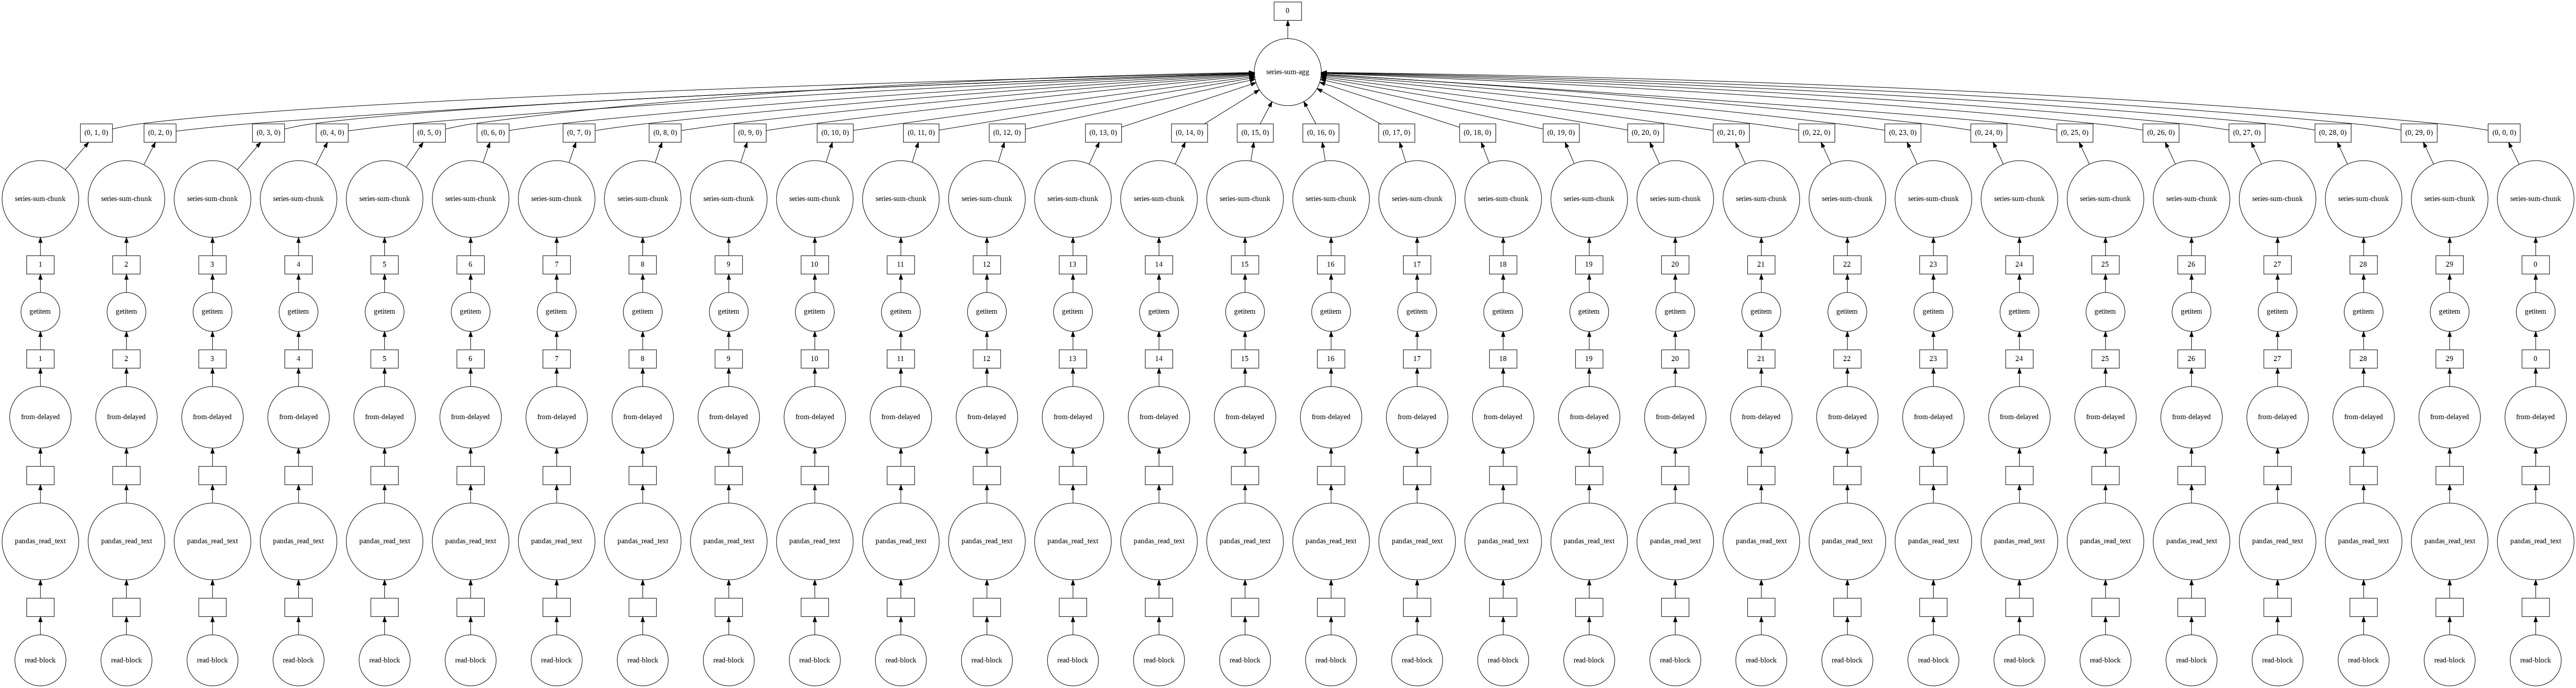

In [0]:
march_data.fare_amount.sum().visualize()

## Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Mar 2016 to predict the pickups in  May 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [0]:
#table below shows few datapoints along with all our features
march_data.head(5)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2016-03-01 00:00:00   2016-03-01 00:07:55                1   
1         1  2016-03-01 00:00:00   2016-03-01 00:11:06                1   
2         2  2016-03-01 00:00:00   2016-03-01 00:31:06                2   
3         2  2016-03-01 00:00:00   2016-03-01 00:00:00                3   
4         2  2016-03-01 00:00:00   2016-03-01 00:00:00                5   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           2.50        -73.976746        40.765152           1   
1           2.90        -73.983482        40.767925           1   
2          19.98        -73.782021        40.644810           1   
3          10.78        -73.863419        40.769814           1   
4          30.43        -73.971741        40.792183           3   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -74.004265         40.746128             1   
1                  N         -74.005943         40.733166             1   
2                  N         -73.974541         40.675770             1   
3                  N         -73.969650         40.757767             1   
4                  N         -74.177170         40.695053             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          9.0    0.5      0.5        2.05          0.00   
1         11.0    0.5      0.5        3.05          0.00   
2         54.5    0.5      0.5        8.00          0.00   
3         31.5    0.0      0.5        3.78          5.54   
4         98.0    0.0      0.0        0.00         15.50   

   improvement_surcharge  total_amount  
0                    0.3         12.35  
1                    0.3         15.35  
2                    0.3         63.80  
3                    0.3         41.62  
4                    0.3        113.80

### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [0]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = march_data[((march_data.pickup_longitude <= -74.15) | (march_data.pickup_latitude <= 40.5774)| \
                   (march_data.pickup_longitude >= -73.7004) | (march_data.pickup_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [0]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = march_data[((march_data.dropoff_longitude <= -74.15) | (march_data.dropoff_latitude <= 40.5774)| \
                   (march_data.dropoff_longitude >= -73.7004) | (march_data.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [0]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(march_data)

In [9]:
frame_with_durations.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           2.50        -73.976746        40.765152   
1                1           2.90        -73.983482        40.767925   
2                2          19.98        -73.782021        40.644810   
3                3          10.78        -73.863419        40.769814   
4                5          30.43        -73.971741        40.792183   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -74.004265         40.746128         12.35    7.916667   
1         -74.005943         40.733166         15.35   11.100000   
2         -73.974541         40.675770         63.80   31.100000   
3         -73.969650         40.757767         41.62    0.000000   
4         -74.177170         40.695053        113.80    0.000000   

   pickup_times      Speed  
0  1.456790e+09  18.947368  
1  1.456790e+09  15.675676  
2  1.456790e+09  38.546624  
3  1.456790e+09        inf  
4  1.456790e+09        inf

In [0]:
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

**Passenger Count :**

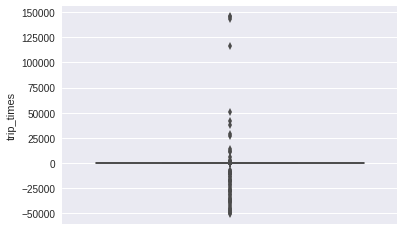

In [0]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y='trip_times', data =frame_with_durations)
plt.show()

In [0]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -50520.23333333333
10 percentile value is 4.016666666666667
20 percentile value is 5.733333333333333
30 percentile value is 7.35
40 percentile value is 9.016666666666667
50 percentile value is 10.883333333333333
60 percentile value is 13.083333333333334
70 percentile value is 15.85
80 percentile value is 19.716666666666665
90 percentile value is 26.466666666666665
100 percentile value is  145867.86666666667


In [0]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 26.466666666666665
91 percentile value is 27.533333333333335
92 percentile value is 28.75
93 percentile value is 30.15
94 percentile value is 31.816666666666666
95 percentile value is 33.86666666666667
96 percentile value is 36.483333333333334
97 percentile value is 40.05
98 percentile value is 45.3
99 percentile value is 54.85
100 percentile value is  145867.86666666667


In [0]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

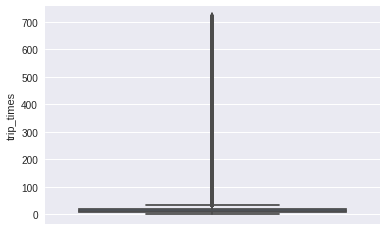

In [0]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

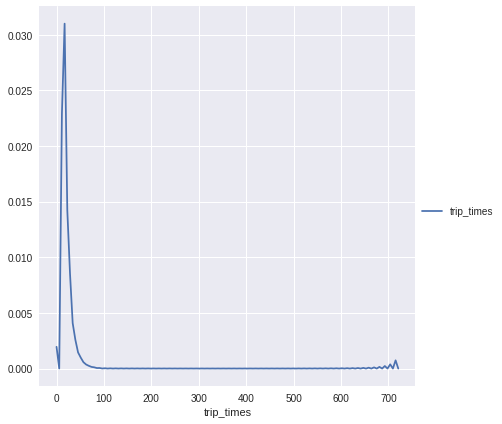

In [0]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [0]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

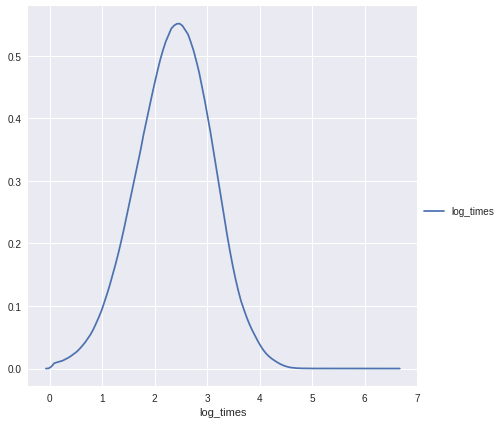

In [0]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

In [0]:
import scipy

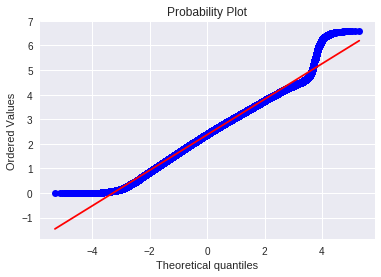

In [0]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

**Passenger Count :**

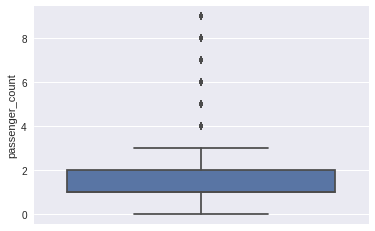

In [12]:
sns.boxplot(y='passenger_count', data =frame_with_durations)
plt.show()

In [14]:
for i in range(0,100,10):
    var =frame_with_durations["passenger_count"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 1
70 percentile value is 1
80 percentile value is 2
90 percentile value is 4
100 percentile value is  9


In [16]:
for i in range(90,100):
    var =frame_with_durations["passenger_count"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 4
91 percentile value is 4
92 percentile value is 5
93 percentile value is 5
94 percentile value is 5
95 percentile value is 5
96 percentile value is 5
97 percentile value is 6
98 percentile value is 6
99 percentile value is 6
100 percentile value is  9


**Observation :** through general knowledge or basic intuition number of passengers should not be more than 6.thus we can consider  the data points having number of passengers less than six

### 4. Speed

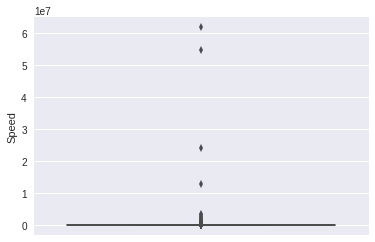

In [0]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.915492957746478
20 percentile value is 7.285714285714286
30 percentile value is 8.392156862745098
40 percentile value is 9.444866920152089
50 percentile value is 10.542056074766355
60 percentile value is 11.779141104294478
70 percentile value is 13.317567567567567
80 percentile value is 15.524999999999999
90 percentile value is 19.726027397260275
100 percentile value is  61801497.46174618


In [0]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 19.726027397260275
91 percentile value is 20.417910447761194
92 percentile value is 21.19935170178282
93 percentile value is 22.10232558139535
94 percentile value is 23.138513513513516
95 percentile value is 24.36
96 percentile value is 25.827232796486093
97 percentile value is 27.671840354767184
98 percentile value is 30.21221864951768
99 percentile value is 34.225352112676056
100 percentile value is  61801497.46174618


In [0]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 34.225352112676056
99.1 percentile value is 34.7906523855891
99.2 percentile value is 35.41841680129241
99.3 percentile value is 36.114285714285714
99.4 percentile value is 36.8944099378882
99.5 percentile value is 37.804100227790435
99.6 percentile value is 38.87323943661972
99.7 percentile value is 40.1741970604246
99.8 percentile value is 41.86466165413534
99.9 percentile value is 44.53772986683577
100 percentile value is  61801497.46174618


In [0]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<44.537)]

In [0]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

11.90567374506287

<b style='font-size:16px'>The avg speed in Newyork speed is 11.905miles/hr, so a cab driver can travel <font color='blue'> 1.98 approx 2 miles per 10min on avg.</font> </b>

> Indented block



### 4. Trip Distance

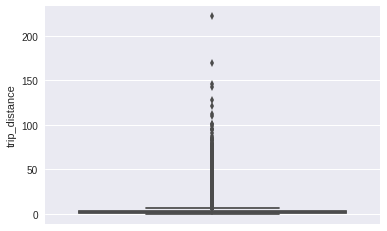

In [0]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.67
20 percentile value is 0.9
30 percentile value is 1.12
40 percentile value is 1.4
50 percentile value is 1.7
60 percentile value is 2.1
70 percentile value is 2.71
80 percentile value is 3.8
90 percentile value is 6.7
100 percentile value is  222.2


In [0]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.7
91 percentile value is 7.32
92 percentile value is 8.1
93 percentile value is 8.87
94 percentile value is 9.6
95 percentile value is 10.4
96 percentile value is 11.45
97 percentile value is 13.53
98 percentile value is 16.9
99 percentile value is 18.5
100 percentile value is  222.2


In [0]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.5
99.1 percentile value is 18.72
99.2 percentile value is 19.0
99.3 percentile value is 19.25
99.4 percentile value is 19.59
99.5 percentile value is 19.98
99.6 percentile value is 20.43
99.7 percentile value is 21.0
99.8 percentile value is 21.7
99.9 percentile value is 23.49
100 percentile value is  222.2


In [0]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<24)]

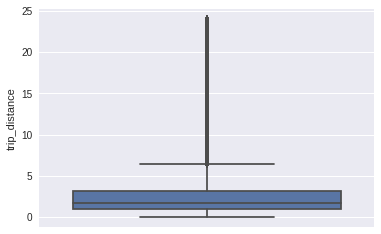

In [0]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 5. Total Fare

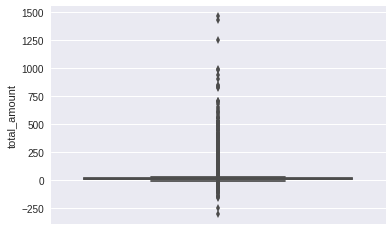

In [0]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -300.8
10 percentile value is 6.8
20 percentile value is 7.9
30 percentile value is 9.3
40 percentile value is 10.35
50 percentile value is 11.8
60 percentile value is 13.56
70 percentile value is 15.96
80 percentile value is 19.8
90 percentile value is 29.15
100 percentile value is  1463.12


In [0]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 29.15
91 percentile value is 30.96
92 percentile value is 33.5
93 percentile value is 36.6
94 percentile value is 39.84
95 percentile value is 43.34
96 percentile value is 47.79
97 percentile value is 53.5
98 percentile value is 60.35
99 percentile value is 69.99
100 percentile value is  1463.12


In [0]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 69.99
99.1 percentile value is 70.0
99.2 percentile value is 70.01
99.3 percentile value is 70.01
99.4 percentile value is 70.84
99.5 percentile value is 72.89
99.6 percentile value is 74.84
99.7 percentile value is 75.41
99.8 percentile value is 81.69
99.9 percentile value is 95.84
100 percentile value is  1463.12


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

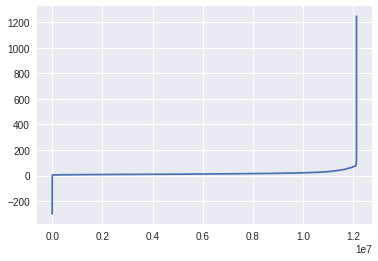

In [0]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

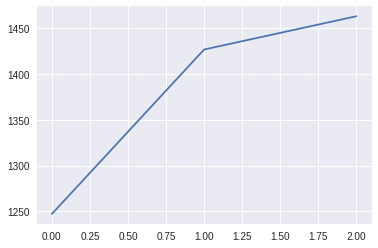

In [0]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

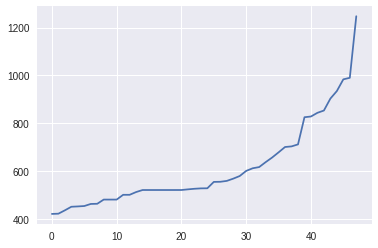

In [0]:

# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points.

In [0]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    temp_frame = new_frame[(new_frame.passenger_count <=6) & (new_frame.passenger_count >0)]
    g = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-g))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [0]:
print ("Removing outliers in the month of  march-2016")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of  march-2016
----
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers from trip times analysis: 30868
Number of outliers from trip distance analysis: 87318
Number of outliers from speed analysis: 23889
Number of outliers from fare analysis: 5859
Total outliers removed 324635
---
fraction of data points that remain after removing outliers 0.9734144397586691


# Data-preperation
## Clustering/Segmentation

In [0]:
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values

In [0]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
clust=[10,20,25,30,40,50]
for increment in clust:
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 25

In [0]:

# so we choose 25 clusters for solve the further problem

# Getting 25 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=25, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [0]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

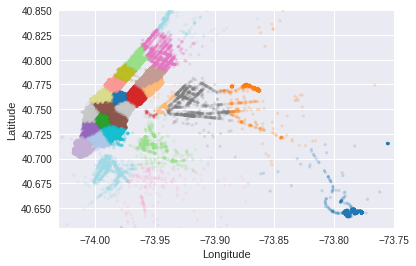

In [0]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning

In [0]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [0]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
march_2016_frame = add_pickup_bins(frame_with_durations_outliers_removed,3,2016)
march_2016_groupby = march_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [0]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
march_2016_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           2.50        -73.976746        40.765152   
1                1           2.90        -73.983482        40.767925   
2                2          19.98        -73.782021        40.644810   
7                1           6.20        -73.788773        40.647758   
8                1           0.70        -73.958221        40.764641   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -74.004265         40.746128         12.35    7.916667   
1         -74.005943         40.733166         15.35   11.100000   
2         -73.974541         40.675770         63.80   31.100000   
7         -73.829208         40.712345         21.80   16.050000   
8         -73.967896         40.762901          8.80    4.983333   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.456790e+09  18.947368               0           33  
1  1.456790e+09  15.675676               9           33  
2  1.456790e+09  38.546624               1           33  
7  1.456790e+09  23.177570               1           33  
8  1.456790e+09   8.428094               8           33

In [0]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
march_2016_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     128
               34                      96
               35                     113
               36                      96
               37                     105

In [0]:


# now do the same operations for months  May of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_may_2016 = dd.read_csv('yellow_tripdata_2016-05.csv')


may_2016_frame,may_2016_groupby = datapreparation(month_may_2016,kmeans,5,2016)


Return with trip times..
Remove outliers..
Number of pickup records =  11836853
Number of outlier coordinates lying outside NY boundaries: 204099
Number of outliers from trip times analysis: 29720
Number of outliers from trip distance analysis: 92187
Number of outliers from speed analysis: 24089
Number of outliers from fare analysis: 6556
Total outliers removed 300266
---
Estimating clusters..
Final groupbying..


In [0]:
month_may_2016.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2016-05-01 00:00:00   2016-05-01 00:17:31                1   
1         2  2016-05-01 00:00:00   2016-05-01 00:07:31                1   
2         2  2016-05-01 00:00:00   2016-05-01 00:07:01                6   
3         2  2016-05-01 00:00:00   2016-05-01 00:19:47                1   
4         2  2016-05-01 00:00:00   2016-05-01 00:06:39                1   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           3.60        -73.985901        40.768040           1   
1           1.68        -73.991577        40.744751           1   
2           1.09        -73.993073        40.741573           1   
3           4.21        -73.991943        40.684601           1   
4           0.56        -74.005280        40.740192           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.983986         40.730099             1   
1                  N         -73.975700         40.765469             1   
2                  N         -73.980995         40.744633             1   
3                  N         -74.002258         40.733002             1   
4                  N         -73.997498         40.737564             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         15.0    0.5      0.5        1.50           0.0   
1          7.5    0.5      0.5        0.88           0.0   
2          6.5    0.5      0.5        1.56           0.0   
3         17.0    0.5      0.5        3.66           0.0   
4          6.0    0.5      0.5        1.46           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.80  
1                    0.3          9.68  
2                    0.3          9.36  
3                    0.3         21.96  
4                    0.3          8.76

In [0]:
may_2016_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           3.60        -73.985901        40.768040   
1                1           1.68        -73.991577        40.744751   
2                6           1.09        -73.993073        40.741573   
3                1           4.21        -73.991943        40.684601   
4                1           0.56        -74.005280        40.740192   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.983986         40.730099         17.80   17.516667   
1         -73.975700         40.765469          9.68    7.516667   
2         -73.980995         40.744633          9.36    7.016667   
3         -74.002258         40.733002         21.96   19.783333   
4         -73.997498         40.737564          8.76    6.650000   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.462061e+09  12.331113               9           33  
1  1.462061e+09  13.410200               5           33  
2  1.462061e+09   9.320665               5           33  
3  1.462061e+09  12.768324              23           33  
4  1.462061e+09   5.052632              18           33

In [0]:
may_2016_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     247
               34                     263
               35                     226
               36                     199
               37                     198

## Smoothing

In [0]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,25):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [0]:
# for each cluster number of 10min intravels with 0 pickups
march_2016_unique = return_unq_pickup_bins(march_2016_frame)
for i in range(25):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(march_2016_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  6
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  84
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  3
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  32
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  7
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  6
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  7
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  63
------------------

In [0]:
may_2016_unique = return_unq_pickup_bins(may_2016_frame)
for i in range(25):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(may_2016_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  0
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  69
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  0
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  20
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  0
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  0
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  1
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  47
------------------

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,25):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,25):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [0]:
#Filling Missing values of march-2016 with 0
# here in march_2016_groupby dataframe the trip_distance represents the number of pickups that are happened
march_2016_fill = fill_missing(march_2016_groupby['trip_distance'].values,march_2016_unique)

#Smoothing Missing values of march-2016
march_2016_smooth = smoothing(march_2016_groupby['trip_distance'].values,march_2016_unique)

In [0]:
may_2016_fill = fill_missing(may_2016_groupby['trip_distance'].values,may_2016_unique)

In [0]:
type(may_2016_fill)

list

In [0]:

print("Number of values filled with zero in march_2016_smooth  data= "+str(countingzeros(may_2016_fill)))

Number of values filled with zero in march_2016_smooth  data= 1274


In [0]:
type(march_2016_smooth)

list

In [0]:
def countingzeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [0]:

print("Number of values filled with zero in march_2016_fill  data= "+str(countingzeros(march_2016_fill)))

Number of values filled with zero in march_2016_fill  data= 1468


In [0]:

print("Number of values filled with zero in may_2016_fill  data= "+str(countingzeros(may_2016_fill)))

Number of values filled with zero in may_2016_fill  data= 1274


In [0]:

print("Number of values filled with zero in march_2016_smooth  data= "+str(countingzeros(march_2016_smooth)))

Number of values filled with zero in march_2016_smooth  data= 0


As We are having 25 clusters there must be 4464*25=111600 pickup values lets see

In [0]:

print("number of 10min intravels among all the clusters ",len(march_2016_fill))

number of 10min intravels among all the clusters  111600


thus it matches .

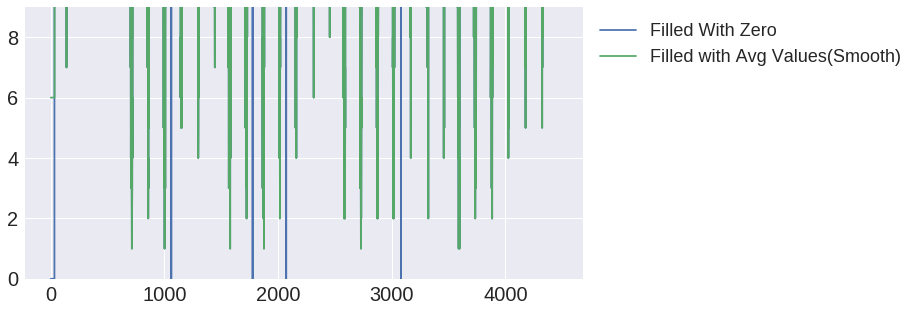

In [0]:

fig = plt.figure(figsize = (10, 5))
plt.plot(march_2016_fill[4464*20:4464*21], label = "Filled With Zero")
plt.plot(march_2016_smooth[4464*20:4464*21], label = "Filled with Avg Values(Smooth)")
plt.legend(bbox_to_anchor=(1, 1), fontsize = 18)
plt.ylim(0,9)
plt.tick_params(labelsize = 20)
plt.show()

In [0]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [0]:

regionwisePickup_may_2016 = []
for i in range(25):
    regionwisePickup_may_2016.append(may_2016_fill[4464*i:((4464*i)+4464)])

## Time series and Fourier Transforms

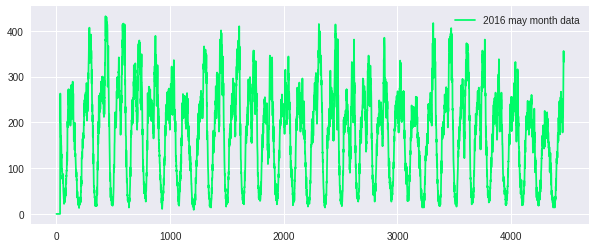

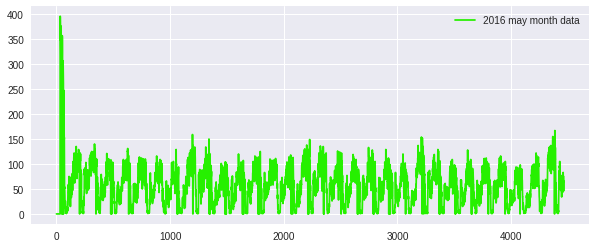

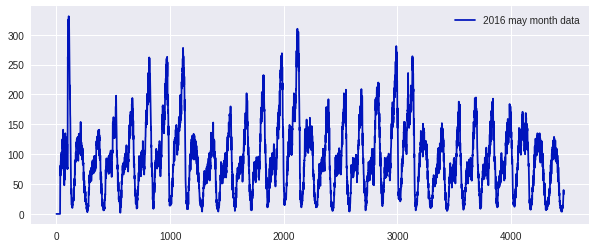

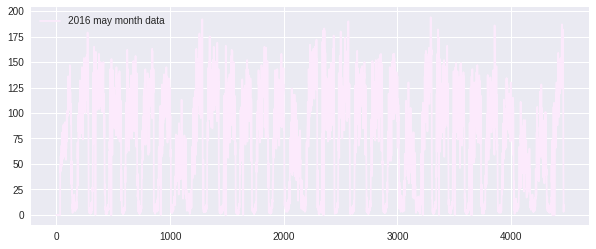

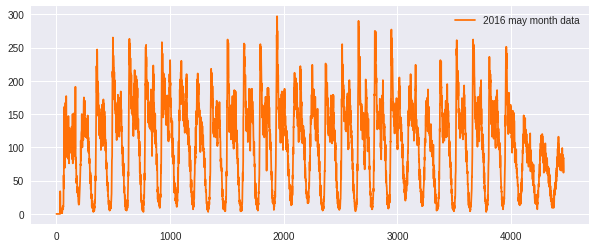

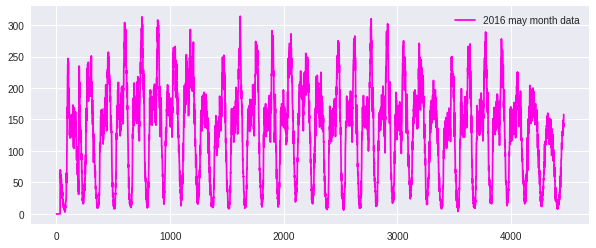

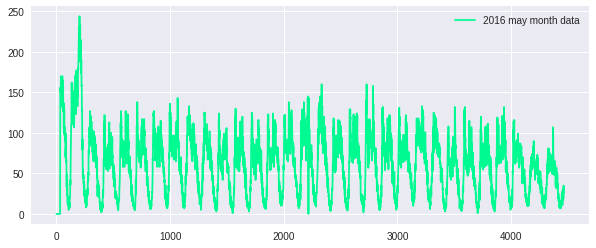

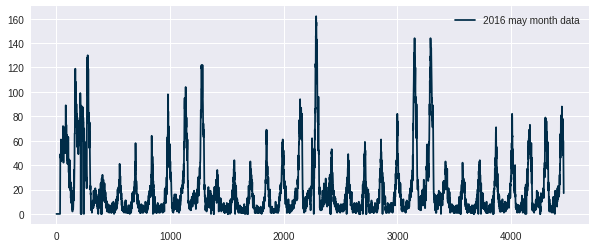

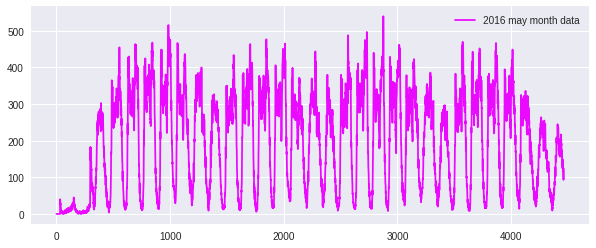

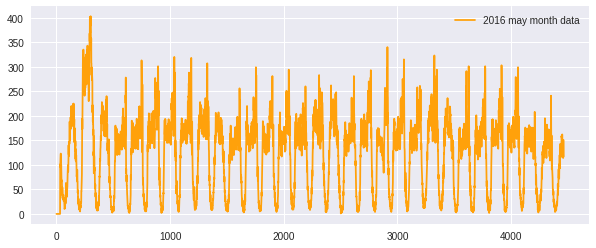

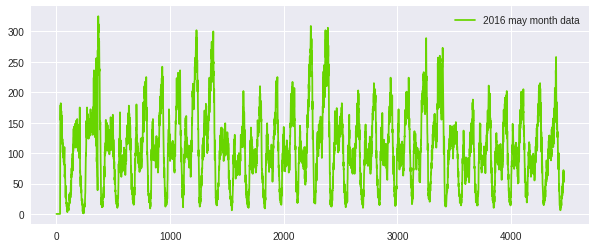

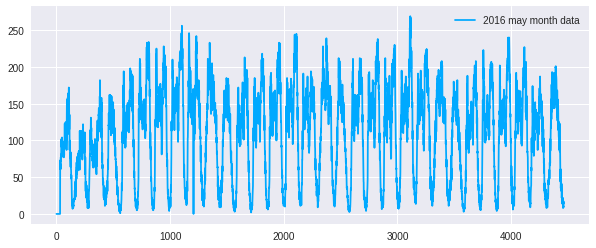

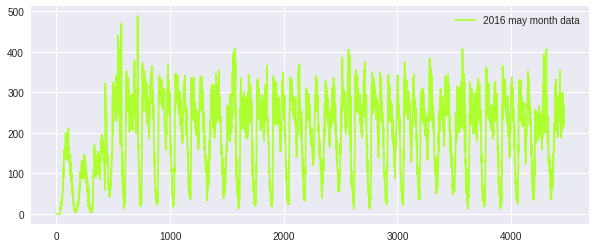

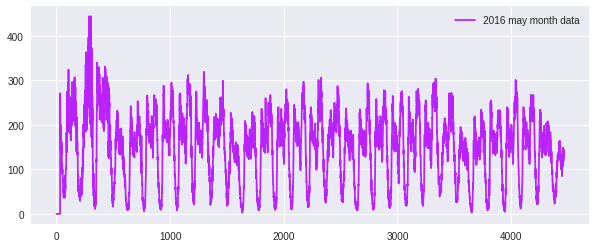

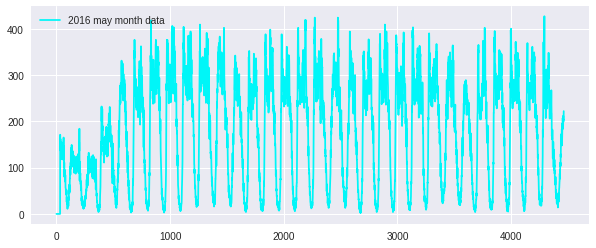

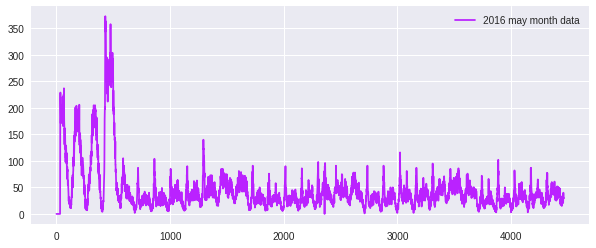

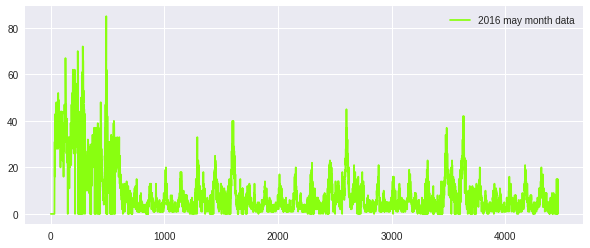

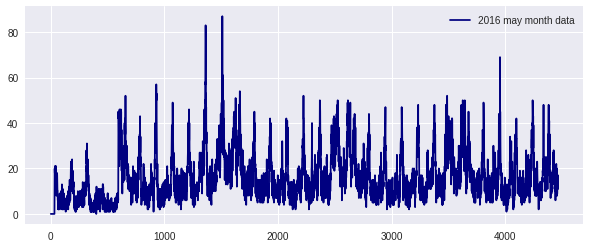

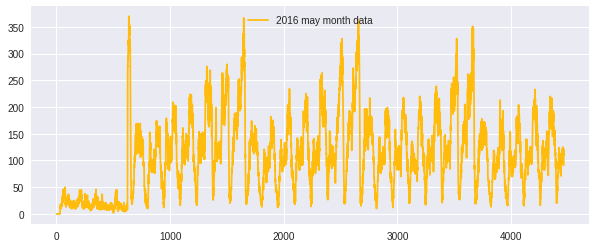

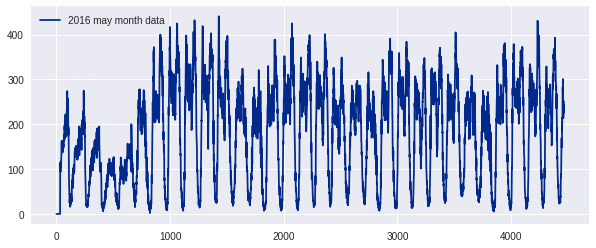

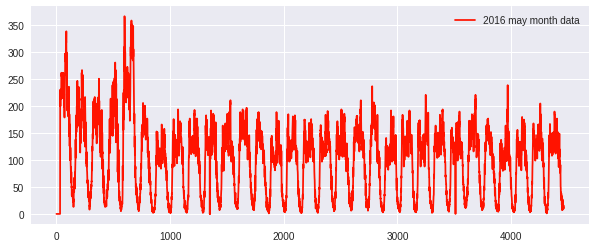

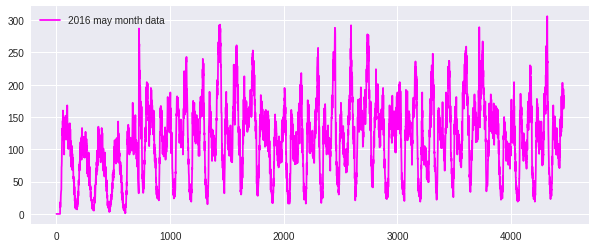

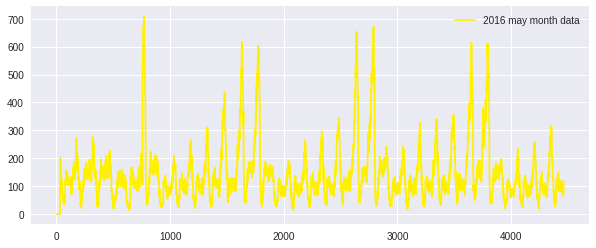

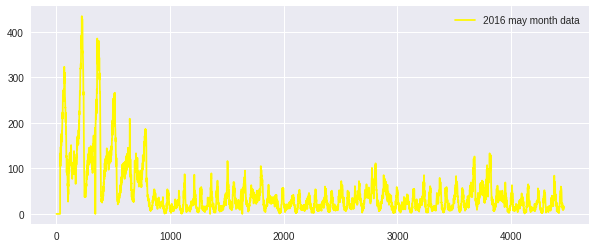

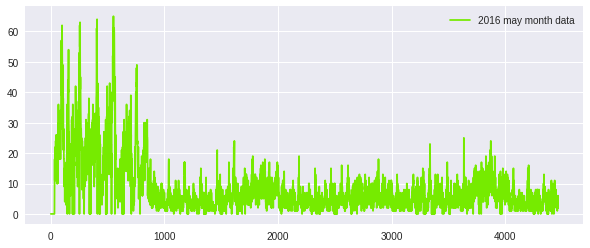

In [0]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
#second_x = list(range(4464,8640))
#third_x = list(range(8640,13104))
for i in range(25):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regionwisePickup_may_2016[i][:4464], color=uniqueish_color(), label='2016 may month data')
   # plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    #plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

In [0]:
len(regionwisePickup_may_2016[1])

4464

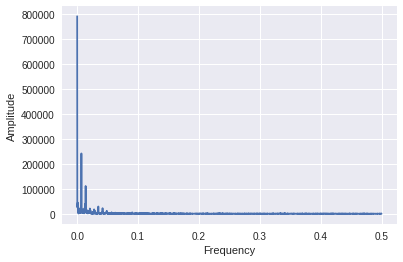

In [0]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(may_2016_fill)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

**Preparing the Dataframe only with x(i) values as march-2016 data and y(i) values as may-2016**

In [0]:
#Preparing the Dataframe only with x(i) values as march-2016 data and y(i) values as may-2016
ratios_ = pd.DataFrame()
ratios_['Given']=march_2016_smooth
ratios_['Prediction']=may_2016_fill
ratios_['Ratios']=ratios_['Prediction']*1.0/ratios_['Given']*1.0

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [0]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*25):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [0]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*25):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [0]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*25):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [0]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*25):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [0]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*25):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [0]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*25):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
mean_err=[0]*10
median_err=[0]*10
ratios_,mean_err[0],median_err[0]=MA_R_Predictions(ratios_,'may')
ratios_,mean_err[1],median_err[1]=MA_P_Predictions(ratios_,'may')
ratios_,mean_err[2],median_err[2]=WA_R_Predictions(ratios_,'may')
ratios_,mean_err[3],median_err[3]=WA_P_Predictions(ratios_,'may')
ratios_,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_,'may')
ratios_,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_,'may')

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [0]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.19159430265598743       MSE:  77904.53052867383
Moving Averages (2016 Values) -                        MAPE:  0.11562459976617022        MSE:  326.2569713261649
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.19348464199010762       MSE:  77493.036890681
Weighted Moving Averages (2016 Values) -               MAPE:  0.11191441861529867       MSE:  312.19755376344085
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.19131161888400436       MSE:  52100.667464157705
Exponential Moving Averages (2016 Values) -         MAPE:  0.11191285778

<b>Plese Note:-</b> The above comparisons are made using March 2016 and May 2016 only

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 2 months of 2016 pickup data and split it such that for every region we have 75% data in train and 25% in test, ordered date-wise for every region

In [0]:


# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists

output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,25):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*4459)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*4459)
    
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regionwisePickup_may_2016[i][r:r+number_of_time_stamps] for r in range(0,len(regionwisePickup_may_2016[i])-number_of_time_stamps)]))
    output.append(regionwisePickup_may_2016[i][5:])
tsne_feature = tsne_feature[1:]

In [0]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 25*4459 == len(output)*len(output[0])

True

In [0]:
predicted_pickup_values = []

# "predicted_pickup_values_list"
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x4463], [x5,x6,x7..x4463], [x5,x6,x7..x4463], ... 40 lists]
predicted_pickup_values_list = []

predicted_value = -1  #it will contain cuurent predicted_value. Default is given -1 which will be replaced later

window_size = 2
for i in range(25):
    for j in range(4464):
        if j == 0:
            predicted_value = regionwisePickup_may_2016[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionwisePickup_may_2016[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionwisePickup_may_2016[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [0]:

len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4459*25

True

In [0]:
tsne_feature

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 4, 2, 2, 5],
       [4, 2, 2, 5, 2],
       [2, 2, 5, 2, 6]])

In [0]:

print("size of total train data :" +str(int(133770*0.75)))
print("size of total test data :" +str(int(133770*0.25)))

size of total train data :100327
size of total test data :33442


In [0]:
print("size of train data for each cluster:" +str(int(4459*0.75)))
print("size of total test data for each cluster:" +str(int(4459*0.25)))

size of train data for each cluster:3344
size of total test data for each cluster:1114


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
#train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
#test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

train_features  = [tsne_feature[i*4459:(4459*i+3344)] for i in range(25)]
test_features  = [tsne_feature[(i*4459)+3344:(4459*(i+1))] for i in range(25)]

In [0]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 25 Number of data points in trian data 3344 Each data point contains 5 features
Number of data clusters 25 Number of data points in test data 1115 Each data point contains 5 features


In [0]:
len(predicted_pickup_values_list)

25

In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:3344] for i in tsne_lat]
tsne_train_flat_lon = [i[:3344] for i in tsne_lon]
tsne_train_flat_weekday = [i[:3344] for i in tsne_weekday]
tsne_train_flat_output = [i[:3344] for i in output]
tsne_train_flat_exp_avg = [i[:3344] for i in predicted_pickup_values_list ]

In [0]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[3344:] for i in tsne_lat]
tsne_test_flat_lon = [i[3344:] for i in tsne_lon]
tsne_test_flat_weekday = [i[3344:] for i in tsne_weekday]
tsne_test_flat_output = [i[3344:] for i in output]
tsne_test_flat_exp_avg = [i[3344:] for i in predicted_pickup_values_list ]

In [0]:
len(train_features[0])

3344

In [0]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,25):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,25):
    test_new_features.extend(test_features[i])

In [0]:
len(train_new_features)

83600

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [0]:
len(tsne_test_exp_avg)

27875

In [0]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(83600, 9)


In [0]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(27875, 9)


### Using Linear Regression

In [0]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

### Using Random Forest Regressor

In [0]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [0]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.02714782 0.04740438 0.14113847 0.19994019 0.27983774 0.00165029
 0.00631961 0.00124907 0.29531242]


### Using XgBoost Regressor

In [0]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [0]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [0]:
#feature importances
x_model.booster().get_score(importance_type='weight')

### Calculating the error metric values for various models

In [0]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

### Error Metric Matrix

In [0]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.11491981263942216       Test:  0.11701440975903304
Exponential Averages Forecasting -           Train:  0.11127073147075771       Test:  0.11283231791122247
Linear Regression -                         Train:  0.11060675388099978       Test:  0.11247471980020741
Random Forest Regression -                   Train:  0.0754644362922688      Test:  0.1104681970661784
XgBoost Regression -                         Train:  0.10617662328771031       Test:  0.11026989265916094
--------------------------------------------------------------------------------------------------------


we can observe that XgBoost Regression works decently when compared with all the models.       
Random Forest regression slightly overfits though it performs decently.

<h3>Adding Fourier Features :</h3>

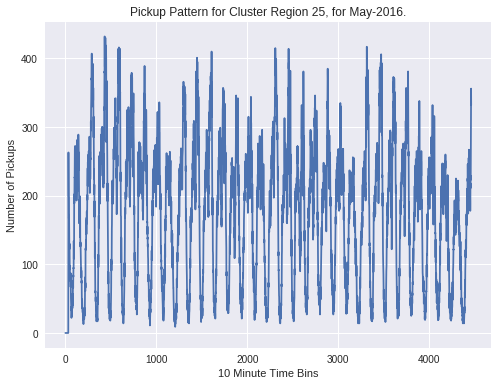

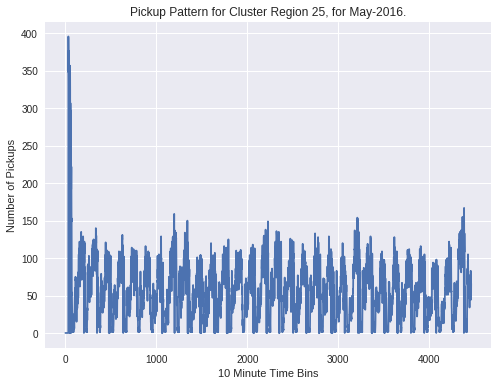

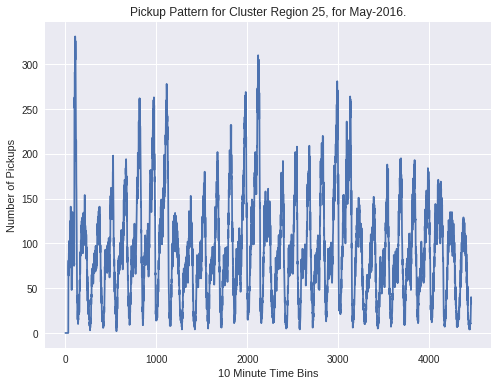

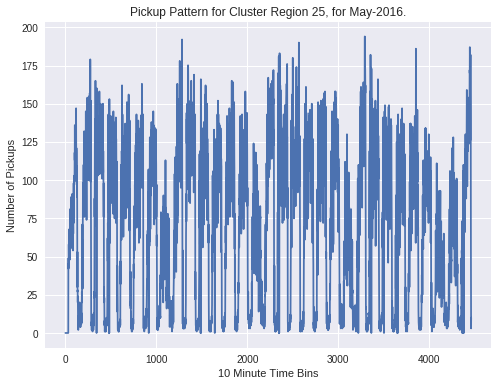

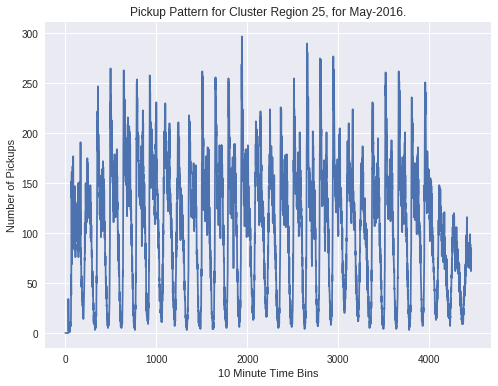

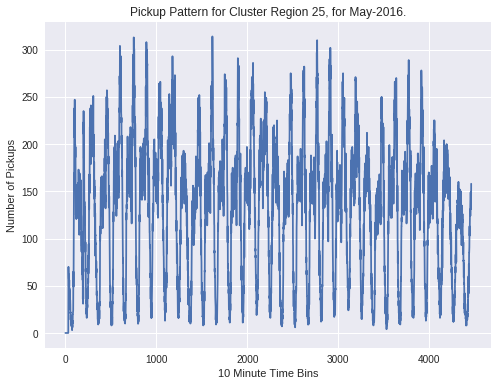

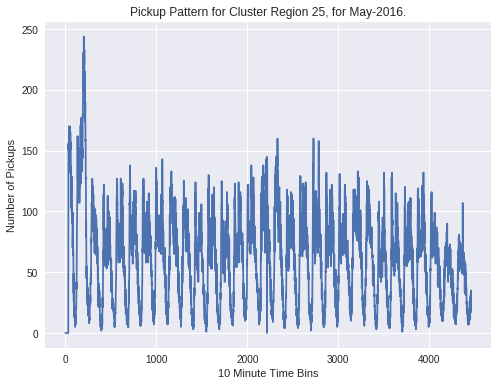

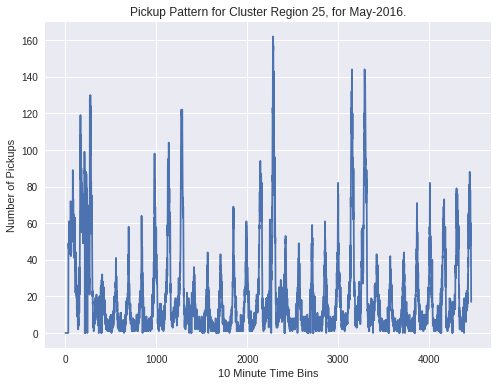

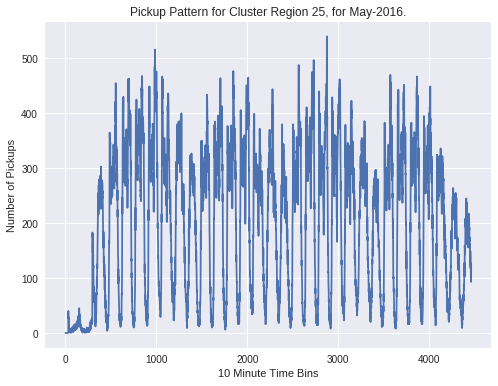

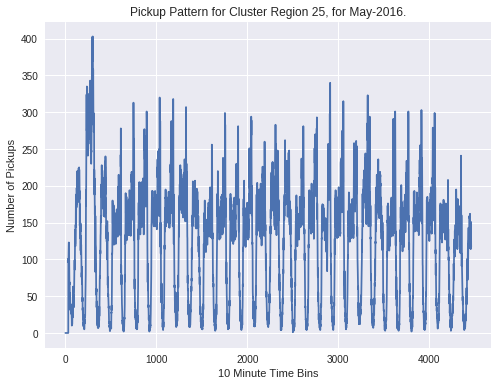

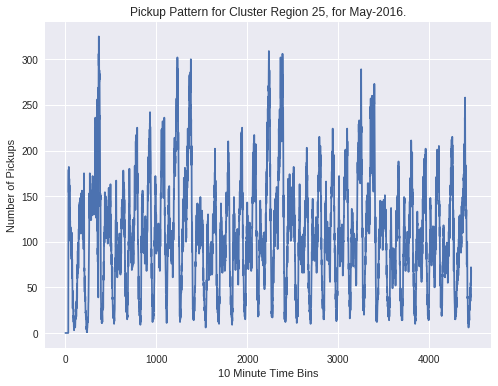

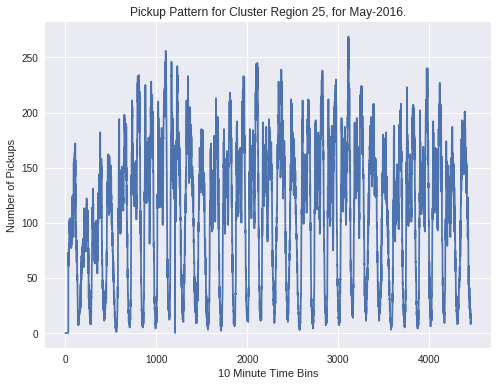

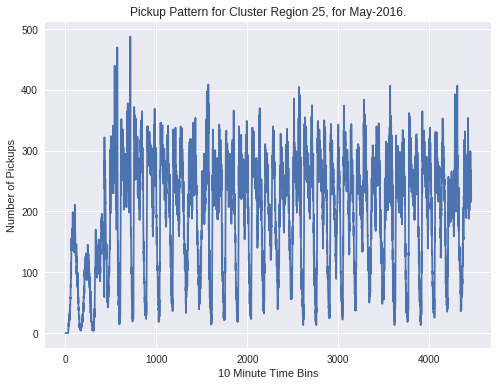

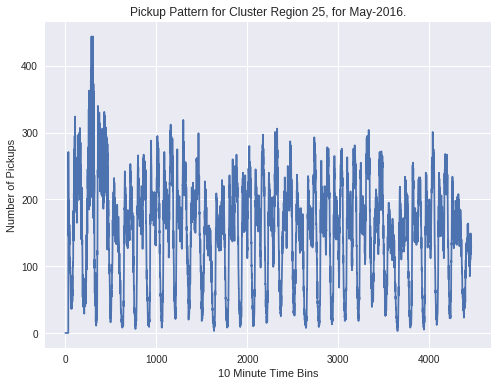

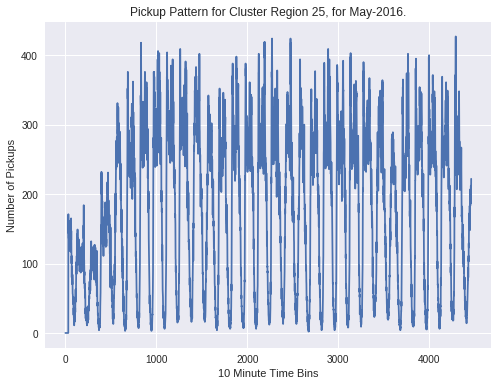

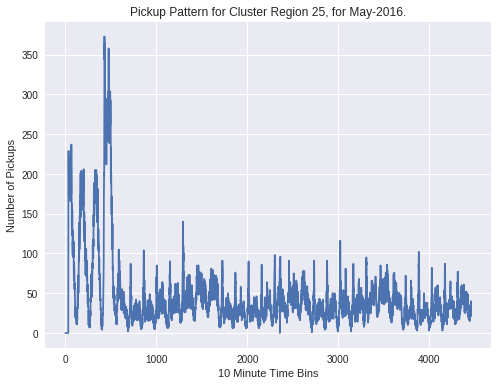

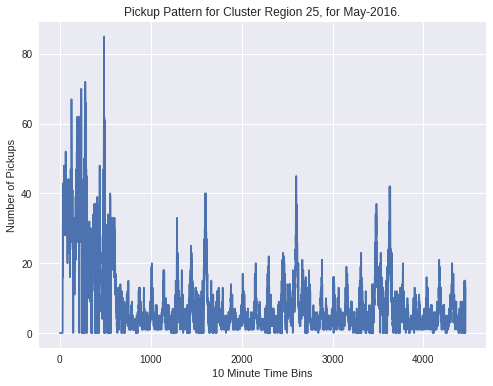

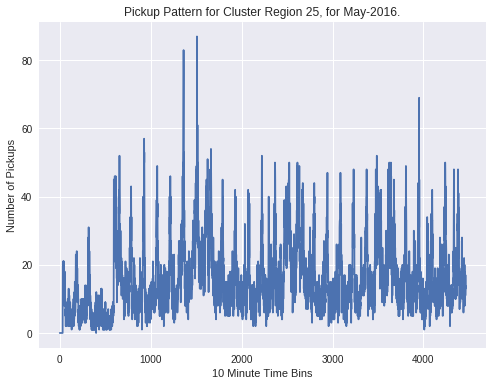

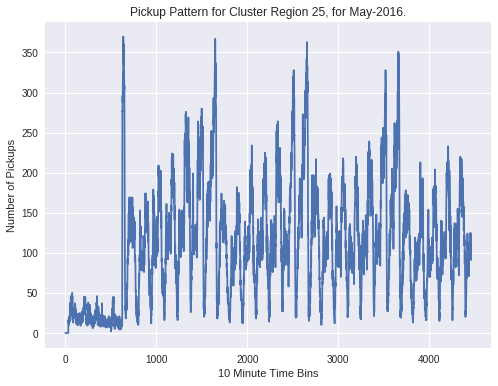

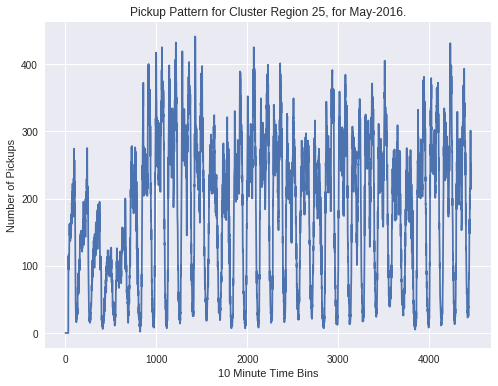

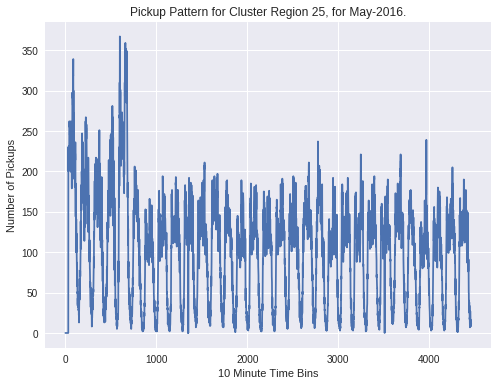

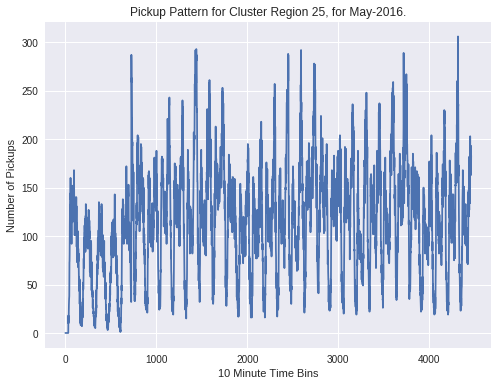

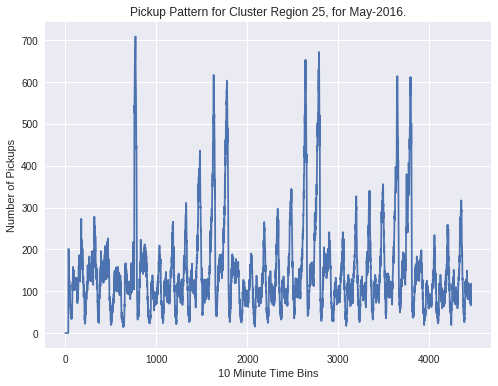

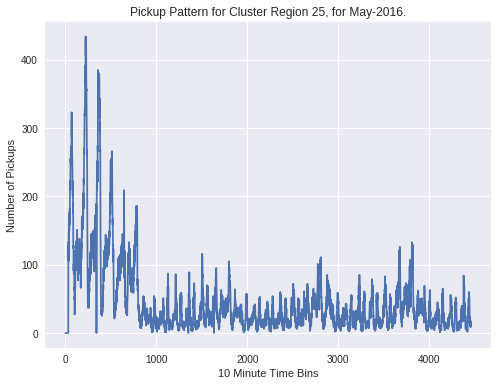

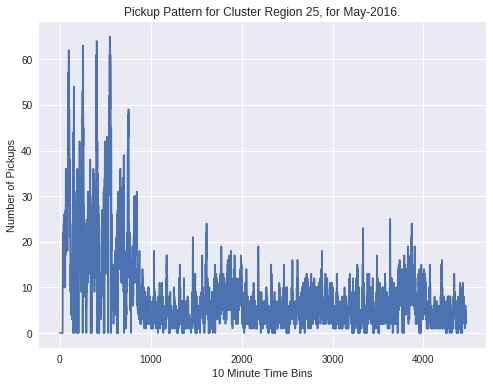

In [0]:

for j in range(25):
    fig = plt.figure(figsize = (8, 6))
    plt.plot(regionwisePickup_may_2016[j][:4464])
    plt.title("Pickup Pattern for Cluster Region "+str(i+1)+", for May-2016.")
    plt.xlabel("10 Minute Time Bins")
    plt.ylabel("Number of Pickups")
    plt.show()

In [0]:

%matplotlib inline

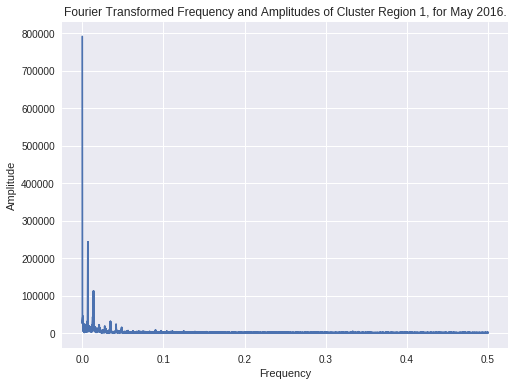

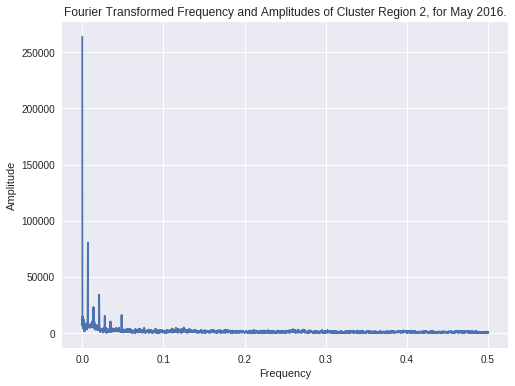

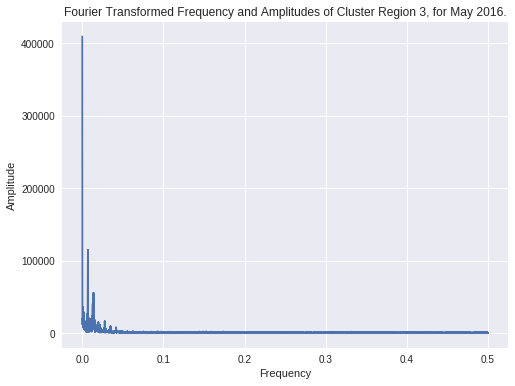

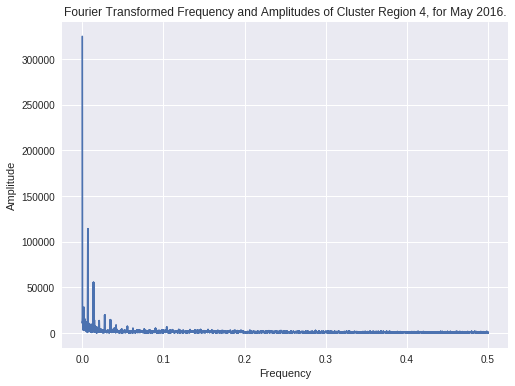

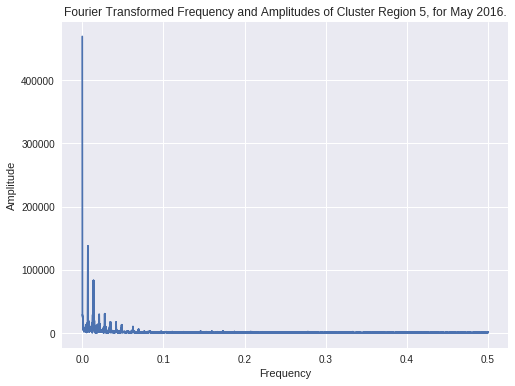

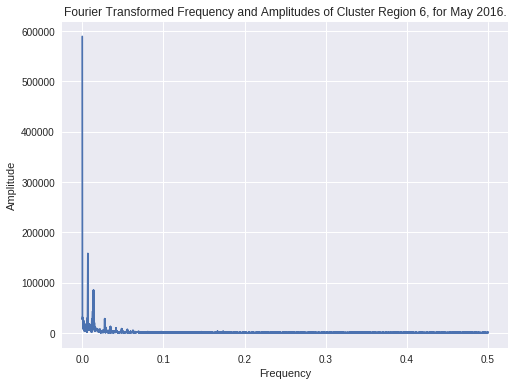

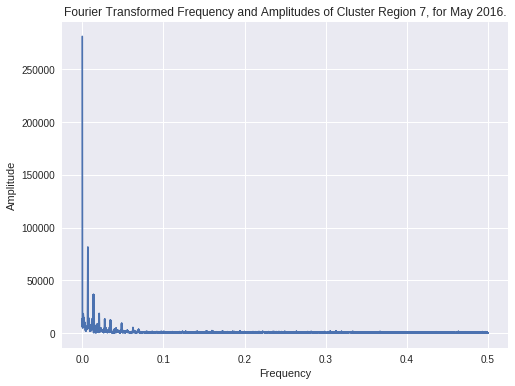

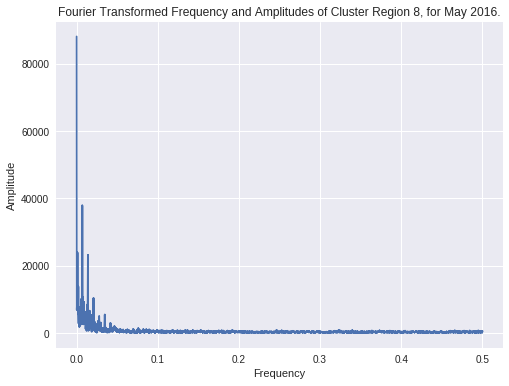

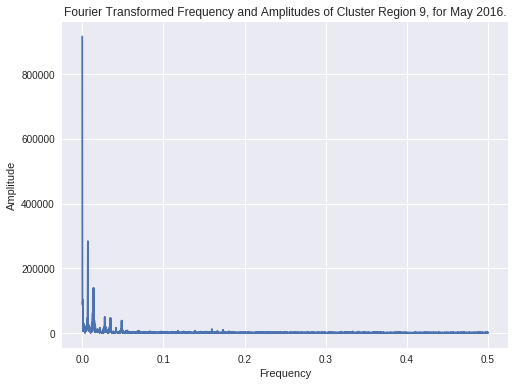

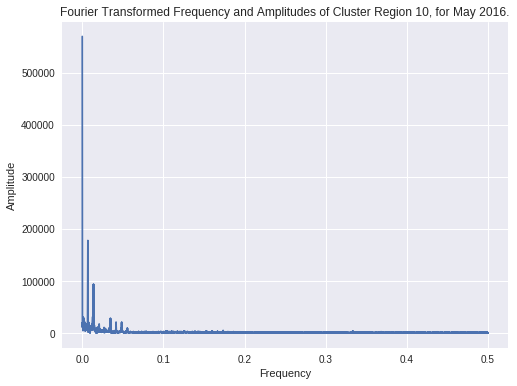

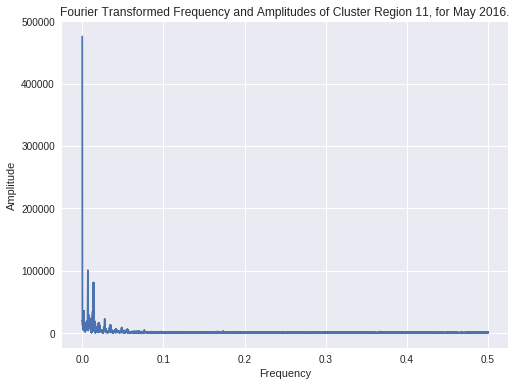

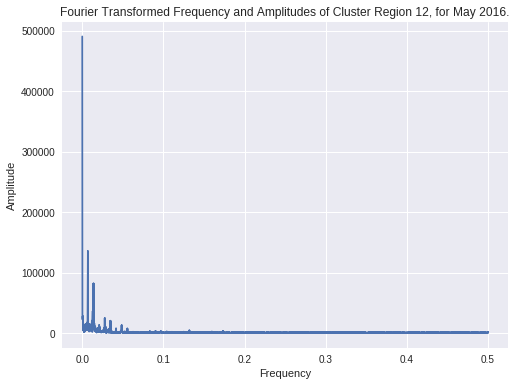

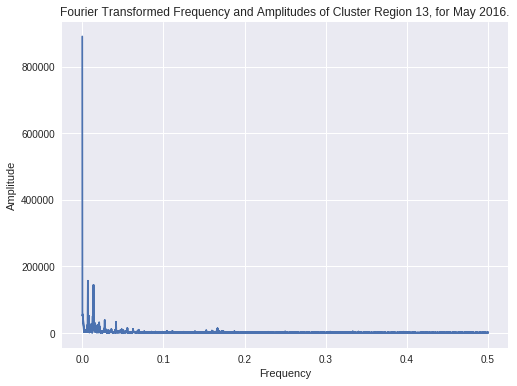

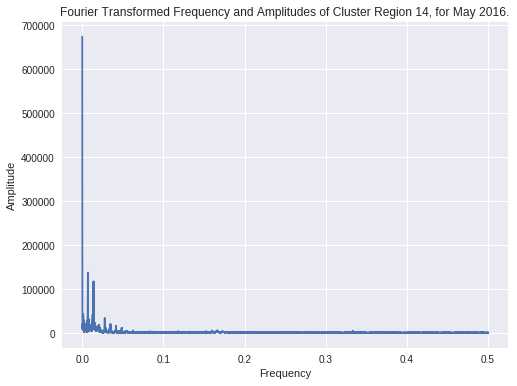

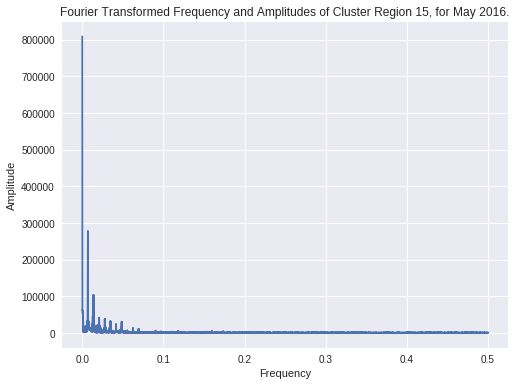

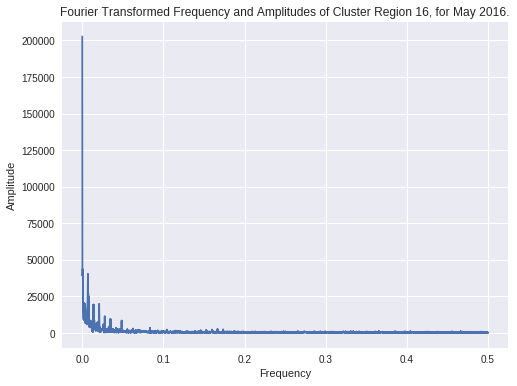

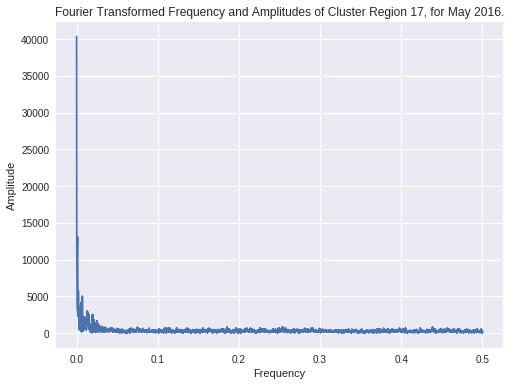

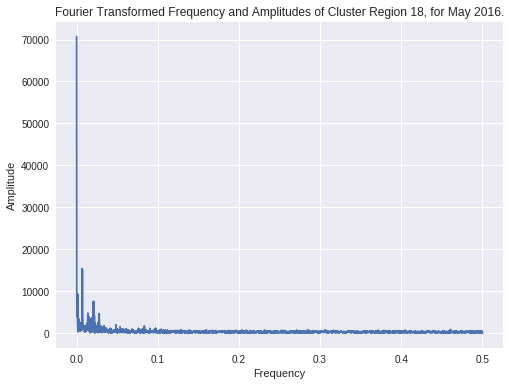

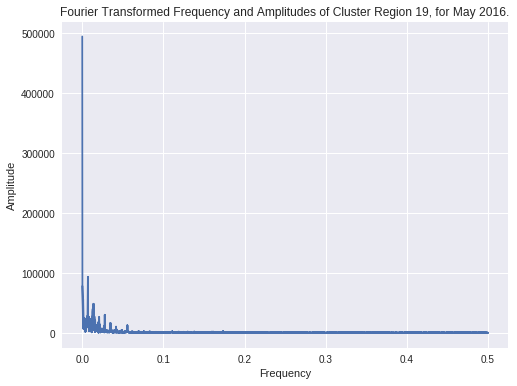

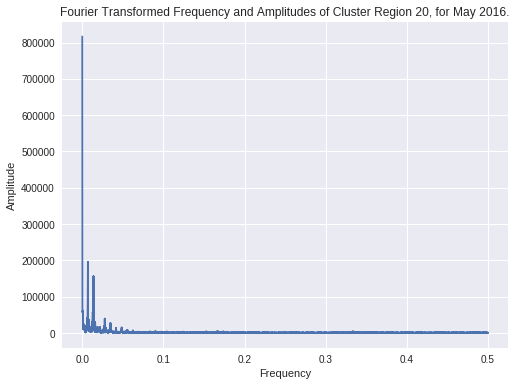

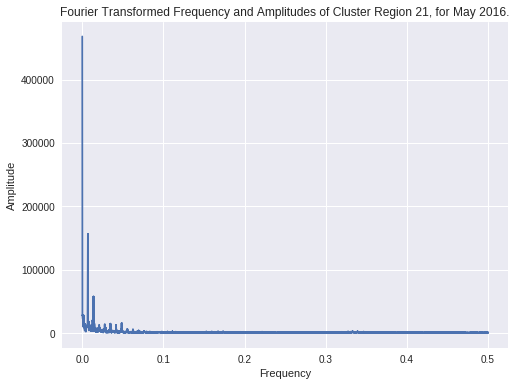

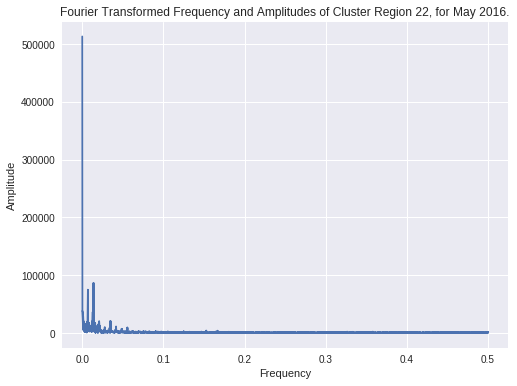

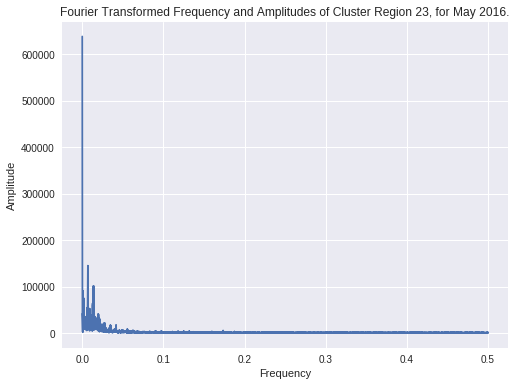

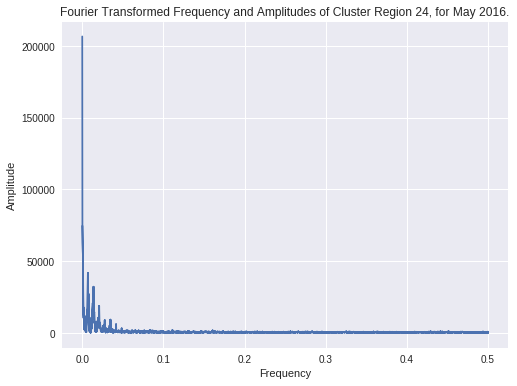

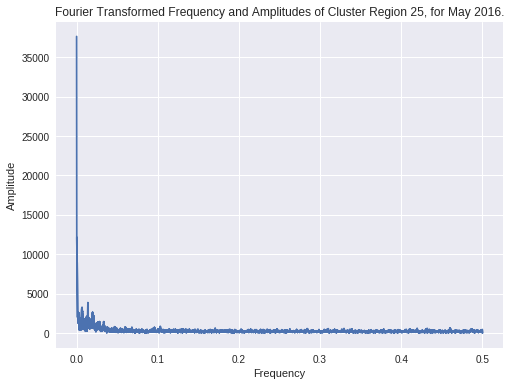

In [0]:
for i in range(25):
    Y  = np.abs(np.fft.fft(regionwisePickup_may_2016[i][0:4464]))
    
    freq = np.abs(np.fft.fftfreq(4464, 1))
    n = len(freq)
    plt.figure(figsize = (8, 6))
    plt.plot(freq[:], Y[:])
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title("Fourier Transformed Frequency and Amplitudes of Cluster Region "+str(i+1)+", for May 2016.")
    plt.show()

In [0]:
dict1={None:None}
type(dict1)

dict

In [0]:
for i in range(0,25):
  t= np.fft.fft(np.array((regionwisePickup_may_2016[i][0:4459])))
  freq = np.fft.fftfreq(4459, 1)
  n = len(freq)
  a=freq[:int(n/2)]; b=np.abs(t)[:int(n/2)]
  c=(-b).argsort()
  freqlist=list(a[c[1:4]])
  amplist=list(b[c[1:4]])
  freqlist.extend(amplist)
  dict1[i]=freqlist

In [0]:
print(df_train.shape)
print(df_test.shape)

(83600, 9)
(27875, 9)


In [0]:
y_tr=[]
y_te=[]
for i in may_2016_frame['pickup_cluster'][0:83600]:
  y_tr.append(dict1[i])
for i in may_2016_frame['pickup_cluster'][83600:111475]:
  y_te.append(dict1[i])  

cd_tr=np.array(y_tr)  
cd_te=np.array(y_te)    

In [0]:
columns = ['f1','f2','f3','a1','a2','a3']
df_fourfeat_tr = pd.DataFrame(data=cd_tr, columns=columns) 

In [0]:
df_fourfeat_tr.head(5)

f1        f2        f3             a1            a2            a3
0  0.006952  0.013904  0.001346  176184.872046  92888.996508  30099.281840
1  0.006952  0.013904  0.013007  156144.420814  84186.897201  39747.321204
2  0.006952  0.013904  0.013007  156144.420814  84186.897201  39747.321204
3  0.000224  0.000449  0.000673   74735.156496  63093.785895  56780.285194
4  0.006952  0.000224  0.000449   93502.725761  78137.240579  62087.550174

In [0]:
columns = ['f1','f2','f3','a1','a2','a3']
df_fourfeat_te = pd.DataFrame(data=cd_te, columns=columns) 

In [0]:
df_fourfeat_te.head(5)

f1        f2        f3             a1             a2             a3
0  0.006952  0.013904  0.000449  156638.232918   58519.301026   28441.756502
1  0.013904  0.006952  0.000224   85630.835390   72786.978294   38395.320052
2  0.006952  0.013904  0.000224  276772.067812  104488.272027   63393.706062
3  0.006952  0.000224  0.000449   93502.725761   78137.240579   62087.550174
4  0.006952  0.013904  0.000897  281559.591421  137529.935337  101782.473905

### Merging these top 3 fourier features to Data Frame

In [0]:
df_test=pd.concat([df_test,df_fourfeat_te],axis=1)
#df_test=df_test.drop('index',axis=1)
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0   163   127   131   111   124  40.761333 -73.979416        6      119   
1   127   131   111   124   102  40.761333 -73.979416        6      109   
2   131   111   124   102   110  40.761333 -73.979416        6      107   
3   111   124   102   110    67  40.761333 -73.979416        6       81   
4   124   102   110    67    73  40.761333 -73.979416        6       71   

         f1        f2        f3             a1             a2             a3  
0  0.006952  0.013904  0.000449  156638.232918   58519.301026   28441.756502  
1  0.013904  0.006952  0.000224   85630.835390   72786.978294   38395.320052  
2  0.006952  0.013904  0.000224  276772.067812  104488.272027   63393.706062  
3  0.006952  0.000224  0.000449   93502.725761   78137.240579   62087.550174  
4  0.006952  0.013904  0.000897  281559.591421  137529.935337  101782.473905

In [0]:
df_train=pd.concat([df_train,df_fourfeat_tr],axis=1)

df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0     0     0     0     0     0  40.761333 -73.979416        4        0   
1     0     0     0     0     0  40.761333 -73.979416        4        0   
2     0     0     0     0     0  40.761333 -73.979416        4        0   
3     0     0     0     0     0  40.761333 -73.979416        4        0   
4     0     0     0     0     0  40.761333 -73.979416        4        0   

         f1        f2        f3             a1            a2            a3  
0  0.006952  0.013904  0.001346  176184.872046  92888.996508  30099.281840  
1  0.006952  0.013904  0.013007  156144.420814  84186.897201  39747.321204  
2  0.006952  0.013904  0.013007  156144.420814  84186.897201  39747.321204  
3  0.000224  0.000449  0.000673   74735.156496  63093.785895  56780.285194  
4  0.006952  0.000224  0.000449   93502.725761  78137.240579  62087.550174

<h3>Including Fourier Features:</h3>

**Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

**Random Forest**

In [0]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [0]:
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'f1', 'f2', 'f3', 'a1', 'a2', 'a3'],
      dtype='object')
[5.54589707e-02 1.31877714e-01 1.13960840e-01 1.64840014e-01
 2.88029564e-01 1.03240480e-02 1.67415244e-02 1.09209965e-03
 2.13754709e-01 7.42477643e-05 2.00726602e-04 7.06066634e-04
 9.81852502e-04 9.92059231e-04 9.65562546e-04]


**XGBoost Regressor**

In [0]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [0]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

### Calculating the error metric values for various models

In [0]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [0]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.11491981263942216       Test:  0.11701440975903304
Exponential Averages Forecasting -           Train:  0.11127073147075771       Test:  0.11283231791122247
Linear Regression -                         Train:  0.11061976186265168       Test:  0.11251011840109576
Random Forest Regression -                   Train:  0.07705540373237789      Test:  0.1101459975560517
XgBoost Regression -                         Train:  0.10598846397416659       Test:  0.11022149049059932
--------------------------------------------------------------------------------------------------------


In [0]:
from sklearn.preprocessing import normalize
df_train_normal = normalize(df_train, axis=0)
df_test_normal = normalize(df_test, axis=0)

<h3>Grid Search</h3>

**Linear Regression**

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
from sklearn import linear_model

In [0]:
tuned_parameters = [{'max_iter': [ 10**0, 10,10**2, 10**3],'alpha':[10**-4, 10**-2, 10**0, 10**2]}]
modelsgd = GridSearchCV(linear_model.SGDRegressor(), tuned_parameters)

In [0]:
modelsgd.fit(df_train_normal, tsne_train_output)
print(modelsgd.best_estimator_)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)


Now with Best Parameters lets train Linear Regression

In [0]:
lr_reg=linear_model.SGDRegressor(alpha=0.0001,max_iter=1000).fit(df_train_normal, tsne_train_output)

y_pred = lr_reg.predict(df_test_normal)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train_normal)
lr_train_predictions = [round(value) for value in y_pred]

**Random Forest**

In [0]:
tuned_parameters = [{'n_estimators': [ 5, 10,20,30,50,100],'max_depth':[5,10,20,30]}]
modelsRF = GridSearchCV(RandomForestRegressor(), tuned_parameters)

In [0]:
modelsRF.fit(df_train, tsne_train_output)
print(modelsRF.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


With Best parameters we shall train RandomForest

In [0]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=1,min_samples_split=2,n_estimators=50,max_depth=10, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [0]:
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'f1', 'f2', 'f3', 'a1', 'a2', 'a3'],
      dtype='object')
[6.36195718e-02 1.64623385e-01 1.28120112e-01 1.91238382e-01
 1.39402197e-01 8.05731102e-03 1.06029137e-02 4.65265882e-04
 2.92848259e-01 4.90476211e-05 9.07431917e-05 1.70018724e-04
 2.77405300e-04 2.13045725e-04 2.22341422e-04]


**XGBoost Regressor**

In [0]:
tuned_parameters = [{'n_estimators': [ 5, 10,20,30,50,100],'max_depth':[5,10,20,30]}]
modelsxgb = GridSearchCV( xgb.XGBRegressor(), tuned_parameters)

In [0]:
modelsxgb.fit(df_train, tsne_train_output)
print(modelsxgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


With Best Parameters lets train XGBregressor:

In [0]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [0]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

### Calculating the error metric values for various models

In [0]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [0]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.11491981263942216       Test:  0.11701440975903304
Exponential Averages Forecasting -           Train:  0.11127073147075771       Test:  0.11283231791122247
Linear Regression -                         Train:  0.5991386205834194       Test:  0.540503765435867
Random Forest Regression -                   Train:  0.10384260342201201      Test:  0.11060545694717408
XgBoost Regression -                         Train:  0.10968957706943865       Test:  0.11163526726485486
--------------------------------------------------------------------------------------------------------


<h3>Random Search</h3>

**Linear Regression **

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:

import random

In [0]:
l1=[  10,10**2, 10**3]
l2=[10**-4, 10**-2, 10**0, 10**2]
tuned_parameters = {'max_iter':  l1,'alpha':l2}
modelsgd1 = RandomizedSearchCV(linear_model.SGDRegressor(), param_distributions= tuned_parameters)

In [0]:
modelsgd1.fit(df_train_normal, tsne_train_output)
print(modelsgd1.best_estimator_)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)


In [0]:
lr_reg=linear_model.SGDRegressor(alpha=0.01,max_iter=100).fit(df_train_normal, tsne_train_output)

y_pred = lr_reg.predict(df_test_normal)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train_normal)
lr_train_predictions = [round(value) for value in y_pred]

**Random Forest**

In [0]:
tuned_parameters = {'n_estimators': [ 5, 10,20,30,50,100],'max_depth':[5,10,20,30]}
modelsRF1 =  RandomizedSearchCV(RandomForestRegressor(), tuned_parameters)

In [0]:
modelsRF1.fit(df_train, tsne_train_output)
print(modelsRF1.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


with best parameters

In [0]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=2,n_estimators=10,max_depth=10, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [0]:
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'f1', 'f2', 'f3', 'a1', 'a2', 'a3'],
      dtype='object')
[1.69684589e-02 2.16843508e-01 1.37301965e-01 2.05714548e-01
 9.68491598e-02 9.73956510e-03 2.38616726e-02 4.96209712e-04
 2.91457204e-01 2.06449907e-05 7.24602800e-05 1.43349411e-04
 1.92957974e-04 1.82448734e-04 1.55848213e-04]


**XGBoost Regressor**

In [0]:
tuned_parameters = {'n_estimators': [ 5, 10,20,30,50,100],'max_depth':[5,10,20,30]}
modelsxgb = RandomizedSearchCV( xgb.XGBRegressor(), tuned_parameters)

In [0]:
modelsxgb.fit(df_train, tsne_train_output)
print(modelsxgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


with best parameters n_estimators=100,max_depth=5

In [0]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [0]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

### Calculating the error metric values for various models

In [0]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [0]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.11491981263942216       Test:  0.11701440975903304
Exponential Averages Forecasting -           Train:  0.11127073147075771       Test:  0.11283231791122247
Linear Regression -                         Train:  0.7289427591754765       Test:  0.7328702377593985
Random Forest Regression -                   Train:  0.10497874792471346      Test:  0.11129861934620229
XgBoost Regression -                         Train:  0.10797959800772491       Test:  0.11072068300516784
--------------------------------------------------------------------------------------------------------


## Conclusion :

<h3>Steps Followed to solve</h3>

1.)Firstly We Discovered that our End customer is Taxi Driver.    
2.)We framed the problem statement as ,At the given location(NewYorkCity) in next 10 mins predict number of pickups.     
3.)Next we defined the constraints such as latency requirement,interpretability and relative errors.    
4.)We defined the performance metric as Mean Absolute Percentage Error(MAPE)     
5.)We are taking Train data as March 2016 data and Test data as May 2016.    
6.)Here we are dealing with large csv files thus we need to use dask library instead of pandas and similarly we tried using new libraries for efficient computatuion.   
7.)Next we converted the date and time format to unix timestamp by defining the function.   
8.)We Performed data cleaning by focusing on the new york city on features such as latitude and longitude,Trip duration,speed and fare.   
9.)Next we moved to section of Data preparation where we cluster the new york city into more than one regions by maintaining inter cluster distance not less than 2.0 miles.     
10.)Based on the Timestamp for each cluster we are doing time binning for every 10 mins followed by smoothing.smoothing meaning for time bins with zero pickups,we are performing aggregation by considering previous timebins.                 
11.)We decided to go with 25 clusters through following contraint which states that the inter cluster distance should not be greater than 2.5 miles     
12.)We are performing feature engineering using ratios, simple moving averages, weighted moving averages, exponential weighted moving averages by considering the data of 25 clusters.   
13.)We computed a MAPE values of random model by considering above features.          
14.)Then we started predictions using the tree based regression models we take 2 months of 2016 pickup data and split it such that for every region we have 75% data in train and 25% in test, ordered date-wise for every region.           
15.)We trained and tested with Tree based models and Linear regression.lets see the performance table.          
<pre>
<h4>Error Metric Matrix Without Fourier Features(Tree Based Regression Methods) -  MAPE</h4>
--------------------------------------------------------------------------------------------------------
Baseline Model -                                   Train:  0.11491981263942216           Test:  0.11701440975       
Exponential Averages Forecasting -                 Train:  0.11127073147075771           Test:  0.112832317911       
Linear Regression -                                Train:  0.11060675388099978           Test:  0.11247471980020741    
Random Forest Regression -                         Train:  0.0754644362922688            Test:  0.1104681970661784
<h4>XgBoost Regression -                           Train:  0.10617662328771031           Test:  0.11026989265916094 </h4>
--------------------------------------------------------------------------------------------------------
</pre>
we can observe that XgBoost Regression performs well.<br/>
16.)We added features from Fourier Transforms of time series data.we took top 3 amplitude and frequency values corresponding to each cluster and merged with orginal data frame. <br/>                                  
17.) Lets see the results after adding the fourier transform features.        
<pre>
<h4>Error Metric Matrix With Fourier Transforms(Tree Based Regression Methods) -  MAPE</h4>
--------------------------------------------------------------------------------------------------------
Baseline Model -                               Train:  0.11491981263942216       Test:  0.117014409759033
Exponential Averages Forecasting -             Train:  0.11127073147075771       Test:  0.112832317911222
Linear Regression -                            Train:  0.11061976186265168       Test:  0.11251011840109576
Random Forest Regression -                     Train:  0.07705540373237789       Test:  0.1101459975560517
<h4>XgBoost Regression -                       Train:  0.10598846397416659       Test:  0.11022149049059932</h4>
--------------------------------------------------------------------------------------------------------
</pre>
18.)We can observe that performances not improved significantly but improved very minutely.XgBoost Regression performance improved from 0.10617 to 0.10598.<br/>                                    
19.) we performed Hyperparameter tuning with GRIDSEARCH Technique lets see the observations.         
<pre><h4>Error Metric Matrix GRID SEARCH Technique(Tree Based Regression Methods) -  MAPE</h4>
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.11491981263942216       Test:  0.11701440975903304
Exponential Averages Forecasting -           Train:  0.11127073147075771       Test:  0.11283231791122247
Linear Regression -                          Train:  0.5991386205834194       Test:  0.540503765435867
Random Forest Regression -                   Train:  0.10384260342201201      Test:  0.11060545694717408
<h4>XgBoost Regression -                     Train:  0.10968957706943865       Test:  0.11163526726485486</h4>
--------------------------------------------------------------------------------------------------------</pre>
20.)Next we performed Hyperparameter tuning with RANDOMSEARCH technique lets see the observation.         
<pre><h4>Error Metric Matrix RANDOM SEARCH Technique (Tree Based Regression Methods) -  MAPE</h4>
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.11491981263942216       Test:  0.11701440975903304
Exponential Averages Forecasting -           Train:  0.11127073147075771       Test:  0.11283231791122247
Linear Regression -                          Train:  0.7289427591754765       Test:  0.7328702377593985
Random Forest Regression -                   Train:  0.10497874792471346      Test:  0.11129861934620229
<h4>XgBoost Regression -                         Train:  0.10797959800772491       Test:  0.11072068300516784</h4>
--------------------------------------------------------------------------------------------------------</pre>

## Comparing All The Models

In [1]:
from prettytable import PrettyTable

In [17]:
x = PrettyTable()

x.field_names = ["Models", "Without Fourier Features", "With Fourier Features", "Grid Search","Random Search"]
x.add_row(['Baseline Model','Train-0.1149,Test-0.117','Train-0.1149,Test-0.1170','Tr-0.114,Te-0.117','Tr-0.1149,Te-0.117'])
x.add_row(['Exponential Avg Forecast','Train-0.1127,test-0.1128','Train-0.111,Test-0.128','Tr-0.1127,Te-0.1128','Tr-0.11127,Te-0.1128'])
x.add_row(['Linear Regression','Train-0.1106,Test-0.112','Train-0.1106,Test-0.1125','Tr-0.599,Te-0.54','Tr-0.728,Te-0.7328'])
x.add_row(['Random Forest','Train-0.075,Test-0.1104','Train-0.077,Test-0.1101','Tr-0.1038,Te-0.1106','Tr-0.1049,Te-0.1112'])
x.add_row(['XGBOOST Regression','Train-0.1061,Test-0.1102','Train-0.1059,Test-0.1102','Tr-0.1096,Te-0.111','Tr-0.1079,Te-0.1107'])
print(x)

                

+--------------------------+--------------------------+--------------------------+---------------------+----------------------+
|          Models          | Without Fourier Features |  With Fourier Features   |     Grid Search     |    Random Search     |
+--------------------------+--------------------------+--------------------------+---------------------+----------------------+
|      Baseline Model      | Train-0.1149,Test-0.117  | Train-0.1149,Test-0.1170 |  Tr-0.114,Te-0.117  |  Tr-0.1149,Te-0.117  |
| Exponential Avg Forecast | Train-0.1127,test-0.1128 |  Train-0.111,Test-0.128  | Tr-0.1127,Te-0.1128 | Tr-0.11127,Te-0.1128 |
|    Linear Regression     | Train-0.1106,Test-0.112  | Train-0.1106,Test-0.1125 |   Tr-0.599,Te-0.54  |  Tr-0.728,Te-0.7328  |
|      Random Forest       | Train-0.075,Test-0.1104  | Train-0.077,Test-0.1101  | Tr-0.1038,Te-0.1106 | Tr-0.1049,Te-0.1112  |
|    XGBOOST Regression    | Train-0.1061,Test-0.1102 | Train-0.1059,Test-0.1102 |  Tr-0.1096,Te-0.111 |

Thus upon comparing all the models ,XGBOOST Regressor after adding fourier features has good MAPE value  
<h4>XgBoost Regression -                       Train:  0.10598846397416659       Test:  0.11022149049059932</h4>